In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

### 0. Read the dataset from previous days

In [2]:
validDf = pd.read_csv("../data/valid_dataset_minimal_day1_2.csv")
campaigns = validDf["Campaign"].unique()

### 1. Modeling the dataset for predictions (linear assumptions - baseline)

#### 1.1 Split into train and validation set (data is already valid, so no weird entries with no cost or no revenue/sessions)

In [3]:
dfCampaigns = {k : validDf[validDf["Campaign"] == k] for k in campaigns}
trainData, valData = {}, {}
relevantKeys = ["Cost", "Revenue", "Sessions"]
for k in campaigns:
    allData = dfCampaigns[k]
#     print(allData.shape, allData.columns)
    # The entry must have an associated cost and at least a revenue or a number of sessions
    usefulData = allData.loc[(allData["Cost"] * (allData["Revenue"] + allData["Sessions"])) > 0]
    usefulData = usefulData.reset_index()[relevantKeys]
    usefulData["Revenue (log)"] = np.log(usefulData["Revenue"] + 1)

    np.random.seed(42)
    perm = np.random.permutation(len(usefulData))
    usefulData = usefulData.to_numpy()[perm]
    nTrain = int(0.8 * len(usefulData))
    
    columns = [*relevantKeys, "Revenue (log)"]
    trainData[k] = pd.DataFrame(usefulData[0 : nTrain], columns=columns)
    valData[k] = pd.DataFrame(usefulData[nTrain :], columns=columns)
    print("Campaign: %s. Df: %s. Useful data: %s. Train: %s. Validation: %s" % \
          (k, str(allData.shape), str(usefulData.shape), str(trainData[k].shape), str(valData[k].shape)))


Campaign: AW - Accessories. Df: (2266, 7). Useful data: (1283, 4). Train: (1026, 4). Validation: (257, 4)
Campaign: AW - Bags. Df: (763, 7). Useful data: (236, 4). Train: (188, 4). Validation: (48, 4)
Campaign: AW - Google Brand. Df: (970, 7). Useful data: (489, 4). Train: (391, 4). Validation: (98, 4)
Campaign: AW - Office. Df: (613, 7). Useful data: (184, 4). Train: (147, 4). Validation: (37, 4)
Campaign: AW - YouTube. Df: (486, 7). Useful data: (194, 4). Train: (155, 4). Validation: (39, 4)
Campaign: AW - Apparel. Df: (2111, 7). Useful data: (824, 4). Train: (659, 4). Validation: (165, 4)
Campaign: All Products. Df: (1583, 7). Useful data: (284, 4). Train: (227, 4). Validation: (57, 4)
Campaign: AW - Dynamic Search Ads Whole Site. Df: (2335, 7). Useful data: (1070, 4). Train: (856, 4). Validation: (214, 4)


### 2. Pure Statistical Model

In [4]:
class StatisticalModel:
    def __init__(self):
        # This model has just a single parameter, computed as the count between targets and inputs
        self.param = np.nan
        
    def fit(self, x, t):
        assert self.param != self.param
        self.param = t.sum() / x.sum()
    
    def predict(self, x):
        assert self.param == self.param
        return x * self.param
    
def errorL1(y, t):
    return np.abs(y - t).mean()

def plot(model, valData, xKey, tKey):
    validCampaigns = list(valData.keys())
    ax = plt.subplots(len(validCampaigns), figsize=(5, 30))[1]
    for i, k in enumerate(validCampaigns):
        x = valData[k][xKey]
        t = valData[k][tKey]
        y = model[k].predict(x)
        ax[i].scatter(x, y, label="%s Predicted" % (tKey))
        ax[i].scatter(x, t)
        ax[i].set_title(k)
        ax[i].legend()
    

### 2.1 Directly modeling f(Cost) = Revenue

### 2.1.1 Cost x Revenue

In [5]:
model_cost_revenue = {}
predictions_cost_revenue = {}
errors_cost_revenue = {}
displayDf = pd.DataFrame()
res_cost_revenue = []
for k in campaigns:
    model_cost_revenue[k] = StatisticalModel()
    model_cost_revenue[k].fit(trainData[k]["Cost"], trainData[k]["Revenue"])
    predictions_cost_revenue[k] = model_cost_revenue[k].predict(valData[k]["Cost"])
    errors_cost_revenue[k] = errorL1(predictions_cost_revenue[k], valData[k]["Revenue"])
    res_cost_revenue.append([k, trainData[k]["Cost"].sum(), trainData[k]["Revenue"].sum(), \
                model_cost_revenue[k].param, errors_cost_revenue[k]])

displayDf = pd.DataFrame(res_cost_revenue, columns=["Campaign", "Cost", "Revenue", "Fit", "Error (L1)"])
display(displayDf)
print("Mean error:", displayDf["Error (L1)"].mean())

,Campaign,Cost,Revenue,Fit,Error (L1)
0,AW - Accessories,8994.95,55265.58,6.144068,125.413346
1,AW - Bags,492.52,588.95,1.195789,7.042511
2,AW - Google Brand,2198.18,2977.58,1.354566,18.295523
3,AW - Office,343.24,1741.43,5.073505,47.213358
4,AW - YouTube,1433.33,239.37,0.167003,1.974700
5,AW - Apparel,3392.44,2743.66,0.808757,6.279377
6,All Products,877.87,1957.13,2.229408,11.869628
7,AW - Dynamic Search Ads Whole Site,6773.64,57654.69,8.511626,104.953979


Mean error: 40.38030283481182


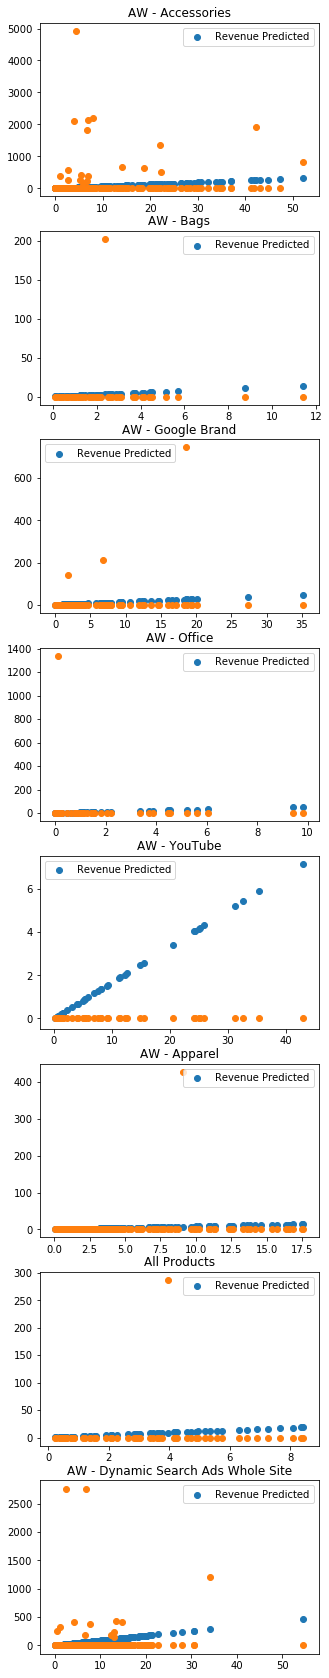

In [6]:
plot(model_cost_revenue, valData, "Cost", "Revenue")

### 2.2 Split in two models:
We'll make the following assumption based on the graphs above. Let's assume that simply predicting f(Cost)=Revenue is too ambigue and let's assume that we can make a statistical analysis based on the number of sessions and the obtained revenue. 

Basically, the idea is that, the more sessions we have, the more revenue we'll have (second column of plots above), so we can make a linear assumption of Revenue ~= f(Sessions) for each campaign.

Then, based on the data, we also see a strong correlation (column 1) between money invested (Cost) and the number of sessions. Thus, we can model Revenue ~= f(Sessions) = ct(Campaign) * #Sessions and Sessions ~= g(Cost), where g is a learned model. Thus, we could model the Revenue (of a Campaign) as Sessions ~= f(g(Cost)) = ct(Campaign) * g(Cost), where ct(Campaign) is a statistical constant, based on the number of revenue divided by number of sessions, for each Campaign.

### 2.2.1 Cost x Session

In [7]:
model_cost_sessions = {}
predictions_cost_sessions = {}
errors_cost_sessions = {}
displayDf = pd.DataFrame()
res_cost_sessions = []
for k in campaigns:
    model_cost_sessions[k] = StatisticalModel()
    model_cost_sessions[k].fit(trainData[k]["Cost"], trainData[k]["Sessions"])
    predictions_cost_sessions[k] = model_cost_sessions[k].predict(valData[k]["Cost"])
    errors_cost_sessions[k] = errorL1(predictions_cost_sessions[k], valData[k]["Sessions"])
    res_cost_sessions.append([k, trainData[k]["Cost"].sum(), trainData[k]["Sessions"].sum(), \
                model_cost_sessions[k].param, errors_cost_sessions[k]])

displayDf = pd.DataFrame(res_cost_sessions, columns=["Campaign", "Cost", "Sessions", "Fit", "Error (L1)"])
display(displayDf)
print("Mean error:", displayDf["Error (L1)"].mean())

,Campaign,Cost,Sessions,Fit,Error (L1)
0,AW - Accessories,8994.95,30904.0,3.435706,18.726930
1,AW - Bags,492.52,2654.0,5.388614,8.627451
2,AW - Google Brand,2198.18,10649.0,4.844462,18.067379
3,AW - Office,343.24,1996.0,5.815173,11.911857
4,AW - YouTube,1433.33,2854.0,1.991167,11.796895
5,AW - Apparel,3392.44,13566.0,3.998892,12.993221
6,All Products,877.87,6847.0,7.799560,14.054805
7,AW - Dynamic Search Ads Whole Site,6773.64,21218.0,3.132437,15.771818


Mean error: 13.993794526571094


Plotting the results for validation set

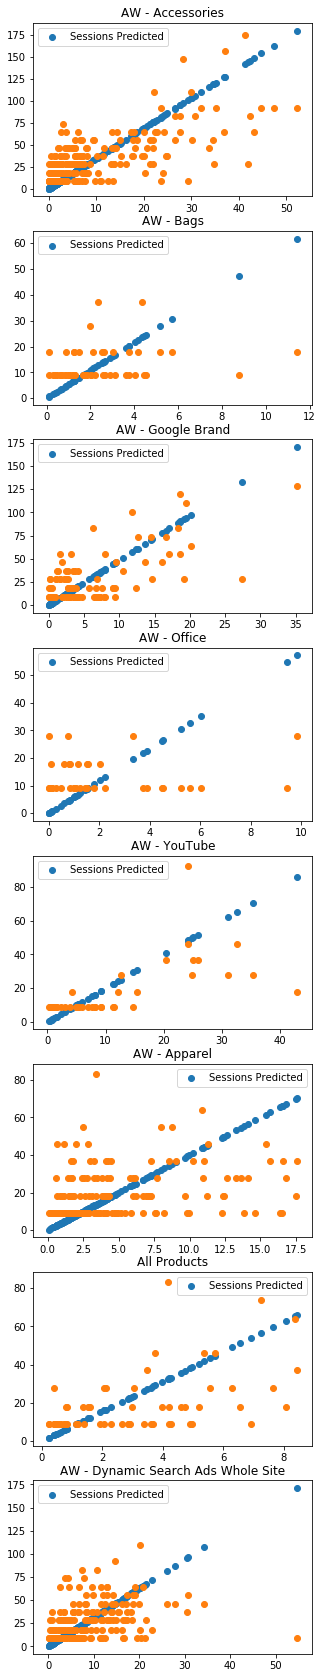

In [8]:
plot(model_cost_sessions, valData, "Cost", "Sessions")

### 2.2.2 Sessions x Revenue

In [9]:
model_sessions_revenue = {}
predictions_sessions_revenue = {}
errors_sessions_revenue = {}
displayDf = pd.DataFrame()
res_sessions_revenue = []
for k in campaigns:
    model_sessions_revenue[k] = StatisticalModel()
    model_sessions_revenue[k].fit(trainData[k]["Sessions"], trainData[k]["Revenue"])
    predictions_sessions_revenue[k] = model_sessions_revenue[k].predict(valData[k]["Sessions"])
    errors_sessions_revenue[k] = errorL1(predictions_sessions_revenue[k], valData[k]["Revenue"])
    res_sessions_revenue.append([k, trainData[k]["Sessions"].sum(), trainData[k]["Revenue"].sum(), \
                model_sessions_revenue[k].param, errors_sessions_revenue[k]])

displayDf = pd.DataFrame(res_sessions_revenue, columns=["Campaign", "Sessions", "Revenue", "Fit", "Error (L1)"])
display(displayDf)
print("Mean error:", displayDf["Error (L1)"].mean())

,Campaign,Sessions,Revenue,Fit,Error (L1)
0,AW - Accessories,30904.0,55265.58,1.788299,127.344066
1,AW - Bags,2654.0,588.95,0.221910,6.802039
2,AW - Google Brand,10649.0,2977.58,0.279611,17.853524
3,AW - Office,1996.0,1741.43,0.872460,47.191323
4,AW - YouTube,2854.0,239.37,0.083872,1.513993
5,AW - Apparel,13566.0,2743.66,0.202245,6.313543
6,All Products,6847.0,1957.13,0.285838,10.485637
7,AW - Dynamic Search Ads Whole Site,21218.0,57654.69,2.717254,101.642283


Mean error: 39.893300796261876


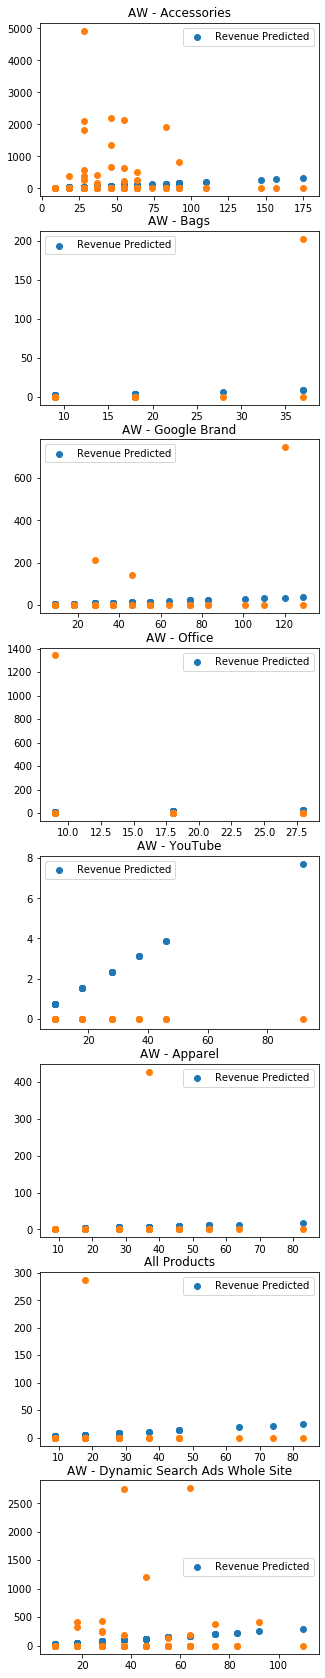

In [10]:
plot(model_sessions_revenue, valData, "Sessions", "Revenue")

#### 2.2.3 Cost x Revenue ~= Cost x Sessions + Sessions x Revenue

In [11]:
displayDf = pd.DataFrame()
errors_cost_revenue = {}
res_cost_revenue_combined = []

class TwoModel(object):
    def __init__(self, modelA, modelB):
        self.modelA = modelA
        self.modelB = modelB
    
    def predict(self, x):
        return self.modelA.predict(self.modelB.predict(x))
models_cost_revenue = {k : TwoModel(model_cost_sessions[k], model_sessions_revenue[k]) for k in valData}

for k in campaigns:
    predictions_cost_revenue[k] = models_cost_revenue[k].predict(valData[k]["Cost"])
    errors_cost_revenue[k] = errorL1(predictions_cost_revenue[k], valData[k]["Revenue"])
    res_cost_revenue_combined.append([k, errors_cost_revenue[k]])

displayDf = pd.DataFrame(res_cost_revenue_combined, columns=["Campaign", "Error (L1)"])
display(displayDf)
print("Mean error:", displayDf["Error (L1)"].mean())

,Campaign,Error (L1)
0,AW - Accessories,125.413346
1,AW - Bags,7.042511
2,AW - Google Brand,18.295523
3,AW - Office,47.213358
4,AW - YouTube,1.974700
5,AW - Apparel,6.279377
6,All Products,11.869628
7,AW - Dynamic Search Ads Whole Site,104.953979


Mean error: 40.38030283481182


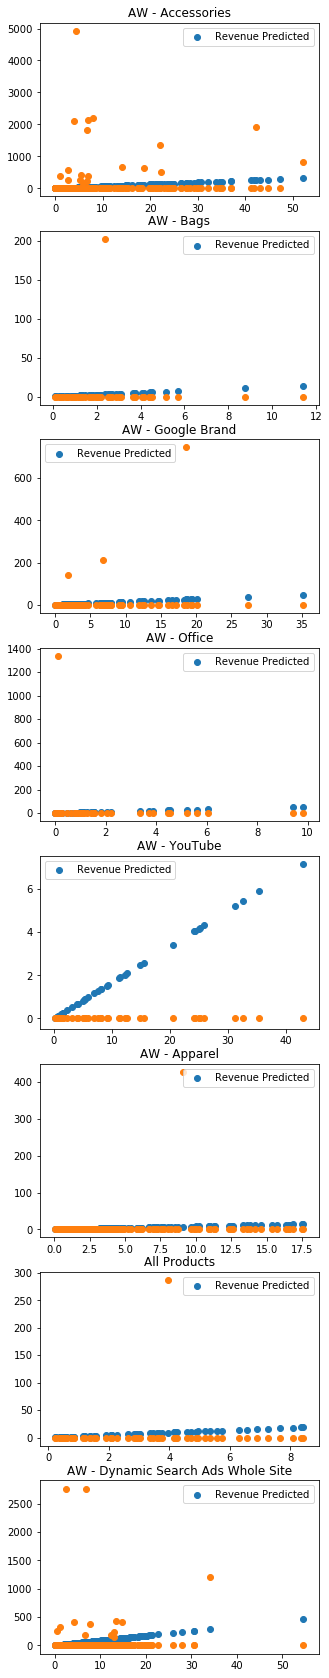

In [12]:
plot(models_cost_revenue, valData, "Cost", "Revenue")